In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import os

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
"""
Function that loads and prepares the dataframe. 

Converts the data into time-series readable.
"""
def initialFormat (filepath, indicatorcode):
    #Reds the file and creates a dataframe from it
    df = pd.read_excel(filepath)
    
    #Choose what to forecast using indicator code
    df_icode = df.loc[df['Indicator Code'] == indicatorcode]
    
    #Dropping these columns as they are not needed for the forecast
    df_icode = df_icode.drop(columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'])
    
    #Swap axis so it is in the proper format
    df_formatted = df_icode.swapaxes("index", "columns")
    
    #Renaming column name to 'values' to make reference easier
    for col_names in df_formatted.columns:
        name = df_formatted.rename(columns={col_names : "Val"})
        return name
    
    return df_formatted

In [4]:
def performance_metrics(y_test, y_pred):
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test )) *100
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    mean = np.mean(y_test)
    
    print("RMSE: ", rmse)
    print("MAPE: ", mape)
    print("MAE: ", mae)
    print("R2 Score: ", r2)
    print("Mean of actual: ", mean)

In [5]:
data = initialFormat('/Users/farhanhabibie/Desktop/Farhan Thesis Code /UG-Project-Farhan/Indonesia Macro Dataset.xlsx',
             'NY.GDP.PCAP.KD.ZG')

In [6]:
copied = data.copy()

In [7]:
index_reset = copied.reset_index()

In [8]:
dataFormatted = index_reset.rename(columns={'index' : 'year'})

In [9]:
#Restructure data with shift
dataFormatted["Target"] = dataFormatted.Val.shift(-1)

In [10]:
dataFormatted.dropna(inplace=True)

In [11]:
#Extract feature & label
X = dataFormatted.iloc[:,0:1].values

In [12]:
y = dataFormatted.iloc[:, -1].values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle=False)

In [14]:
model = XGBRegressor(objective = 'reg:squarederror', n_estimators=1000)

In [15]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [16]:
y_pred = model.predict(X_test)

In [23]:
df_pred = pd.DataFrame({'Predicted' : y_pred})

In [24]:
result = pd.concat([dataFormatted.tail(len(X_test)).reset_index(drop=True), df_pred], axis = 1)

In [25]:
result

,year,Val,Target,Predicted
0,2007,4.946465,4.620033,4.945343
1,2008,4.620033,3.247327,4.945343
2,2009,3.247327,4.812282,4.945343
3,2010,4.812282,4.748221,4.945343
4,2011,4.748221,4.606284,4.945343
5,2012,4.606284,4.151271,4.945343
6,2013,4.151271,3.639143,4.945343
7,2014,3.639143,3.555440,4.945343
8,2015,3.555440,3.759694,4.945343
9,2016,3.759694,3.842334,4.945343


RMSE:  1.0050248426884165
MAPE:  23.30910840783094
MAE:  0.87523915625198
R2 Score:  -3.1391194973827146
Mean of actual:  4.070104338163304


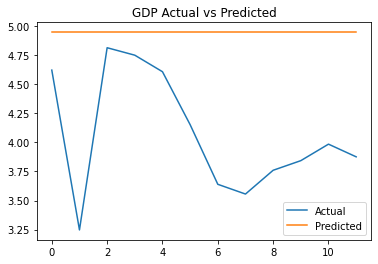

In [21]:
df_compare = pd.DataFrame({'Actual' : y_test, 'Predicted' : y_pred})
df_compare.plot(title='GDP Actual vs Predicted')
performance_metrics(y_test, y_pred)

In [26]:
df_compare

,Actual,Predicted
0,4.620033,4.945343
1,3.247327,4.945343
2,4.812282,4.945343
3,4.748221,4.945343
4,4.606284,4.945343
5,4.151271,4.945343
6,3.639143,4.945343
7,3.555440,4.945343
8,3.759694,4.945343
9,3.842334,4.945343
